In [1]:
import math, pysal, random, shutil
import numpy as np
import csv
import pandas as pd
import csvkit as ck
import itertools

In [2]:
# Suppression criteria:
#MIN_COM_CT = 2000     # Minimum number of commuters per polygon feature
MIN_COM_CT = 20000     # Minimum number of commuters per polygon feature
MAX_INT_COM = 40  # Maximum percentage of internal commuters per polygon feature

In [3]:
Countshapefile = r"C:\Lorraine\DATA\REGIONS\NIW01_sort.shp"

In [4]:
w = pysal.rook_from_shapefile("C:\Lorraine\DATA\REGIONS\NIW01_sort.shp",idVariable='LABEL')
Simil = pysal.open("C:/Lorraine/DATA/REGIONS/simNI.csv")
Similarity = np.array(Simil)
db = pysal.open('C:\Lorraine\DATA\REGIONS\MatrixCSV2.csv', 'r')
dbf = pysal.open(r'C:\Lorraine\DATA\REGIONS\NIW01_sortC.dbf', 'r')
ids = np.array((dbf.by_col['LABEL']))
commuters = np.array((dbf.by_col['Total'],dbf.by_col['IDNO']))
commutersint = commuters.astype(int)
comm = commutersint[0]
#floor = int(MIN_COM_CT + 100)
#changed the floor to 10,000 commuters
floor = int(MIN_COM_CT + 1000)
solution = pysal.region.Maxp(w=w,z=Similarity,floor=floor,floor_variable=comm)
regions = solution.regions
#print regions
writecsv = r"C:\Lorraine\DATA\REGIONS\reg_output20k.csv"
csv = open(writecsv,'w')
csv.write('"LABEL","REG_ID"\n')
for i in range(len(regions)):
        for lines in regions[i]:
            csv.write('"' + lines + '","' + str(i+1) + '"\n')
csv.close()


flows = r"C:\Lorraine\DATA\REGIONS\MatrixCSV2.csv"
regs = r"C:\Lorraine\DATA\REGIONS\reg_output20k.csv"
wardflows = pd.read_csv(flows)
regoutput = pd.read_csv(regs)
merged = pd.merge(wardflows, regoutput)
#duplicate REG_ID column as the index to be used later
merged['REG_ID2'] = merged['REG_ID']
merged.to_csv("C:\Lorraine\DATA\REGIONS\merged20k.csv", index=False)
mergedcsv = pd.read_csv("C:\Lorraine\DATA\REGIONS\merged20k.csv",index_col='WardID_1') #index this dataframe using the WardID_1 column
flabelList = pd.read_csv("C:\Lorraine\DATA\REGIONS\merged20k.csv", usecols = ["WardID", "REG_ID"]) #create list of all FLabel values

reg_id = "REG_ID"
ward_flows = "RegIntFlows"
flds = [reg_id, ward_flows] #create list of fields to be use in search

dict_ref = {} # create a dictionary with for each REG_ID a list of corresponding FLABEL fields


#group the dataframe by the REG_ID column
idgroups = flabelList.groupby('REG_ID')['WardID'].apply(lambda x: x.tolist())
print idgroups

idgrp_df = pd.DataFrame(idgroups)

csvcols = mergedcsv.columns

#create a list of column names to pass as an index to select columns
columnlist = list(mergedcsv.columns.values)

mergedcsvgroup = mergedcsv.groupby('REG_ID').sum()
mergedcsvgroup.describe()
idList = idgroups[2]
#df4 = pd.DataFrame()
#df5 = pd.DataFrame()
col_ids = idList #ward id no

regiddf = idgroups.index.get_values()

pairs = list(itertools.product(regiddf, repeat=2))


#create a new dataframe with pairlists and summed data
pairlist = pd.DataFrame(pairs,columns=['origID','destID'])
#print pairlist.tail()
header_pairlist = ["origID","destID","flow"]
header_intflow = ["RegID", "RegID2", "regflow"]
dfflows = pd.DataFrame(columns=header_intflow)


data = []
origin = []
destination = []

set = 0 #global variable


resultdf = pd.DataFrame()
dfOflowsOut = pd.DataFrame()
dfDflowsIn = pd.DataFrame()

def flows():
    pass

def flows(mergedcsv, ward_lista, ward_listb):
    global resultdf #this is important to specify that the dataframe is global
    """Return the sum of all the cells in the row/column intersections
    of ward_lista and ward_listb."""
        
    regionflows = mergedcsv.loc[ward_lista, ward_listb]
    regionflowsum = regionflows.values.sum()
    
    gridoutput = [ax, bx, regionflowsum]
    gridax = [ax + 1]
    headerax = ["OrigRegID"]
    gridbx = [bx + 1]
    headerbx = ["DestRegID"]
    flow = [regionflowsum]
    headerflow = ["flow"]
    
    dfheaders = ["OrigRegID", "DestRegID", "Flow"]
    rflows = pd.DataFrame.from_dict(gridoutput, orient='columns').transpose()
    
    origin = []
    destination = []
    data = []
    
    origin.append(gridax)
    destination.append(gridbx)
    data.append(flow)
    
    #global df
    df = pd.DataFrame(np.column_stack([origin, destination, data]), columns=['origin', 'destination', 'flow'])
    
    
    resultdf = resultdf.append(df)#need to store the output using resultdf = 
    
   
    return origin
    return destination
    return data
    return df
    return resultdf
#function to calculate the out flows per region of origin
def OflowsOut(mergedcsv,ward_lista):
    global dfOflowsOut
    OFlowsOut = mergedcsv.loc[ward_lista, '0':'581']
    #print OFlowsOut
    OFlowsOutsum = OFlowsOut.values.sum()
    
    flowsOut = []
    flowsOut.append(OFlowsOutsum)
    dfOut = pd.DataFrame(np.column_stack([ax, flowsOut]), columns=['origin', 'OflowsOut'])
    dfOflowsOut = dfOflowsOut.append(dfOut)
    
    return dfOflowsOut

#function to calculate the in flows per region of destination 
def DflowsIn(mergedcsv,ward_listastr):
    global dfDflowsIn
    DFlowsIn = mergedcsv.loc[:, ward_listastr]
    #print DFlowsIn
    DFlowsInsum = DFlowsIn.values.sum()
    
    flowsIn = []
    flowsIn.append(DFlowsInsum)
    dfIn = pd.DataFrame(np.column_stack([ax, flowsIn]), columns=['destination', 'DflowsIn'])
    dfDflowsIn = dfDflowsIn.append(dfIn)
    
    return dfDflowsIn
    
for ax, group_a in enumerate(idgroups):
    #ward_list = idgroups[group_a]
    ward_lista = map(int, group_a)
    ward_listastr = map(str, group_a)
    #print ward_lista
    #this is for the total origin out flows for the region
    #flows_out = OflowsOut(mergedcsv, ward_lista)
        

    for bx, group_b in enumerate(idgroups[ax:], start=ax):
        ward_listb = map(str, group_b)
        ward_listbint = map(int, group_b)
        #print ward_listb

        flow_ab = flows(mergedcsv, ward_lista, ward_listb)
        #this is for the total origin out flows for the region
        flows_out = OflowsOut(mergedcsv, ward_lista)
        flows_in = DflowsIn(mergedcsv, ward_listastr)
        
        
        if ax != bx:
            flow_ba = flows(mergedcsv, ward_listbint, ward_listastr)
        else:
            flow_ba = flow_ab
        





REG_ID
1     [64, 65, 66, 69, 70, 72, 73, 74, 75, 76, 77, 7...
2     [545, 546, 547, 548, 549, 550, 551, 552, 553, ...
3     [139, 140, 155, 160, 495, 498, 499, 501, 502, ...
4     [51, 55, 56, 61, 62, 251, 252, 253, 255, 256, ...
5     [306, 307, 308, 309, 310, 311, 312, 313, 315, ...
6     [351, 352, 353, 354, 355, 356, 357, 358, 359, ...
7     [20, 21, 22, 23, 24, 25, 26, 27, 30, 31, 32, 3...
8     [46, 234, 235, 236, 237, 238, 239, 240, 241, 2...
9     [95, 101, 212, 213, 214, 216, 217, 218, 219, 2...
10    [11, 17, 173, 174, 175, 176, 178, 179, 180, 18...
11    [19, 189, 190, 191, 192, 193, 194, 195, 196, 1...
12    [215, 228, 278, 284, 290, 293, 389, 390, 391, ...
13    [67, 68, 71, 79, 83, 172, 177, 187, 374, 375, ...
14    [121, 143, 145, 146, 147, 151, 165, 166, 409, ...
15             [125, 132, 153, 157, 158, 159, 162, 169]
16    [123, 124, 129, 131, 135, 149, 150, 156, 161, ...
17    [122, 126, 127, 128, 130, 133, 134, 136, 137, ...
18    [276, 277, 279, 280, 281, 282, 283,

In [5]:
print resultdf.head()
print resultdf.tail()
#print destination
pairlistCSV = r"C:\Lorraine\DATA\REGIONS\pairlist_regions20k.csv"
#index false or true?, originally false
resultdf.to_csv(pairlistCSV, index=False)

#calculate internal flows
#pull out internal flows for each region where origin and destination ids are the same
internalflows = resultdf[resultdf.origin == resultdf.destination]
print internalflows
#print dfOflowsOut.head()

#clean up dataframe to remove duplicate outflow values for each region
dfOflowsout_clean = dfOflowsOut.drop_duplicates()
#in and Out flow counts are out of sync. IDs start at 0 instead of 1
dfOflowsout_clean['origin']+= 1
print dfOflowsout_clean.tail()


OFout = r"C:\Lorraine\DATA\REGIONS\O_Flows_Out20k.csv"
#dfOflowsOut.to_csv(OFout, index=True)
dfOflowsout_clean.to_csv(OFout, index=True)


#clean up dataframe to remove duplicate inflow values for each region
dfDflowsin_clean = dfDflowsIn.drop_duplicates()
#in and Out flow counts are out of sync. IDs start at 0 instead of 1
dfDflowsin_clean['destination']+= 1
print dfDflowsin_clean.tail()


DFin = r"C:\Lorraine\DATA\REGIONS\D_Flows_In20k.csv"
#dfOflowsOut.to_csv(OFout, index=True)
dfDflowsin_clean.to_csv(DFin, index=True)

   origin  destination   flow
0       1            1  22864
0       1            2     69
0       1            2     12
0       1            3    786
0       1            3    307
   origin  destination   flow
0      23           25    193
0      24           24   9986
0      24           25     48
0      24           25     18
0      25           25  17311
   origin  destination   flow
0       1            1  22864
0       2            2  25140
0       3            3  12087
0       4            4  16375
0       5            5  19458
0       6            6  19169
0       7            7  18202
0       8            8  23548
0       9            9  15739
0      10           10   7291
0      11           11  10663
0      12           12  12519
0      13           13  10692
0      14           14   5441
0      15           15  10663
0      16           16   9372
0      17           17  14362
0      18           18  24778
0      19           19  21049
0      20           20   8531
0      21 

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
#merge all the df together to create a regression df. 
#It will contain O,D, Ox, Oy, Dx, Dy, flow, OflowsOut, DflowsIn, Distance

#regressdf = pd.merge(resultdf, dfOflowsout_clean)
#regressdf = pd.merge(pd.merge(resultdf, dfOflowsout_clean, on='origin'),dfDflowsin_clean, on='destination')
#print regressdf.head()

#regressionCSV = r"C:\Temp\AllNI\regions_regression.csv"
#regressdf.to_csv(regressionCSV, index=True)

In [7]:
#Prep geometry for plotting
import pandas as pd
import geopandas as gp
#Read in wards for NI
#wards = ("C:/Temp/AllNI/regression/NI/NI_wards_2001.shp")
#wards = gp.read_file(wards)
wards = gp.read_file(Countshapefile)
wards = wards.to_crs(epsg=29902)

regression_shapes = wards.merge(regoutput, on='LABEL')


In [8]:
print regression_shapes.head()
regions = regression_shapes.dissolve(by='REG_ID')
print len(regions)

   POLY_ID         NAME   LABEL  Dup  ID  \
0       38   Aldergrove  95AA01    0   0   
1      365       Balloo  95AA02    0   1   
2      496  Ballycraigy  95AA03    0   2   
3      143        Clady  95AA04    0   3   
4       40    Cranfield  95AA05    0   4   

                                            geometry  REG_ID  
0  POLYGON ((313965.2220684135 376688.4141154027,...      20  
1  POLYGON ((315062.2144054914 385599.0353375467,...      25  
2  POLYGON ((316913.4564701284 385423.0143484771,...      25  
3  POLYGON ((323749.4401245777 376730.6842595014,...      21  
4  POLYGON ((307690.7535608921 388145.8189820722,...      25  
25


In [9]:
#Join local values to wards

#regflows = pd.DataFrame(mergedcsv, columns =['LABEL', 'REG_ID', 'Total', 'TotRegFlows'])
#regvalues = pd.merge(regflows, wards[['LABEL', 'geometry']], left_on='LABEL', right_on='LABEL')
#regvalues = gp.GeoDataFrame(regvalues)
#print regvalues.head()
#constructedregions = local_vals.dissolve(by='REG_ID')
#constructedregions.head()
#constructedregions.count()

25
REG_ID
1    POINT (307986.1294898643 420813.4150252204)
2    POINT (242589.6925865025 379059.1517437343)
3    POINT (331892.2356049615 383932.9628120925)
4    POINT (298251.5303352628 356171.9368010241)
5    POINT (339727.1748480059 335954.3017901148)
Name: centroid_column, dtype: object


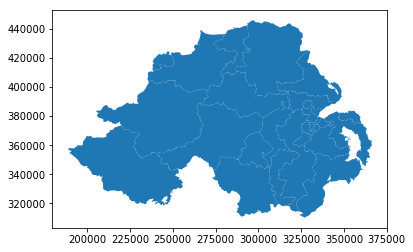

In [10]:
#Plot total reg flow values: darker blue is greater flows
import matplotlib.pyplot as plt

print len(regions.geometry)
#generate centroids
regions['centroid_column'] = regions.centroid

#generate area
regions['area'] = regions.area / 10**6 ##convert from m to km

reg_centroids = regions.loc[:,'centroid_column']
print reg_centroids.head()

reg_area = regions.loc[:,'area']


fig = plt.figure()
ax = fig.add_subplot(111)
regions.plot(ax=ax)
plt.show()

#fig = plt.figure(figsize=(12,12))
#ax = fig.add_subplot(111)
#constructedregions.plot('TotRegFlows', cmap='Blues', ax=ax)
#wards.plot('LABEL', cmap='Blues', ax=ax)
#ax.set_xlim([170000,371000])
#ax.set_ylim([305000,450000])
#plt.show()

In [11]:
#merge all the df together to create a regression df.
# df's are resultdf, dfDflowsin_clean, dfOflowsout_clean, reg_centroids, reg_area
#It will contain O,D, Ox, Oy, Dx, Dy, flow, OflowsOut, DflowsIn, Distance
from functools import reduce


print(type(resultdf))
print(type(dfDflowsin_clean))
print(type(dfOflowsout_clean))


#this is the line which drops a region or an index at the end
regressdf = pd.merge(pd.merge(resultdf, dfOflowsout_clean, on='origin'),dfDflowsin_clean, on='destination')


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [12]:
#separate centroids into x and y columns
#reg_centroids.str.strip('()').str.split(', ', expand=True).rename(columns={0:'X', 1:'Y'})
regions["x"] = regions.centroid.map(lambda p: p.x)
regions["y"] = regions.centroid.map(lambda p: p.y)
xy = regions.loc[:,'x':'y']
x = regions.loc[:, 'x']
y = regions.loc[:, 'y']
xy['origindex'] = xy.index
xy['destindex'] = xy.index
xyorig = pd.DataFrame(xy)
xyorig = xyorig.rename(columns = {'x':'origx'})
xyorig = xyorig.rename(columns = {'y':'origy'})

xydest = pd.DataFrame(xy)
xydest = xydest.rename(columns = {'x': 'destx'})
xydest = xydest.rename(columns = {'y': 'desty'})


regressdfnew = pd.merge(regressdf, xyorig, left_on=['origin'], right_on=['origindex'], how='inner')
regressdfnew2 = pd.merge(regressdfnew, xydest, left_on=['destination'], right_on=['destindex'], how='inner')

regresscols = ['origin', 'destination', 'flow', 'OflowsOut', 'DflowsIn', 'x_orig', 'y_orig', 'x_dest', 'y_dest']

#print regressdfnew2.columns


regressdf2 = regressdfnew2[['origin', 'destination', 'flow', 'OflowsOut', 'DflowsIn', 'origx', 'origy', 'destx', 'desty']]

print regressdf2.head()

import math

pd.options.mode.chained_assignment = None  # default='warn'

def calculateDistance(x1,y1,x2,y2):
    #changed from math.sqrt
    dist = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    return dist

regressdf2['distance'] = regressdf2.apply(lambda x:calculateDistance(x.loc['origx'], x.loc['origy'], x.loc['destx'], x.loc['desty']), axis=1) 


#check to see if the orig and destination id's have changed from the previous row using .shift
regressdf2['origsameid'] = regressdf2.origin == regressdf2.origin.shift(1)
regressdf2['destsameid'] = regressdf2.destination == regressdf2.destination.shift(1)
#print regressdf2.head()
#then where origsameid and destsameid are both = TRUE then switch orig and dest ids
#this step is due to the repetition of orig dest ids. The second repeated matching pair should be switched so that the pairs are all unique.

#find the rows which need swapping
print regressdf2['origsameid'].dtypes
#convert boolean true/false to int
regressdf2['origsameid'] = regressdf2['origsameid'].astype(int)
regressdf2['destsameid'] = regressdf2['destsameid'].astype(int)
#print regressdf2.head()


regressdf2['eq'] = regressdf2.apply(lambda row: row['origsameid'] == 1 and row['destsameid'] ==1, axis=1).astype(int)
print regressdf2.head()
s = regressdf2['eq'] ==1

regressdf2.loc[s, ['origin', 'destination']] = regressdf2.loc[s, ['destination','origin']].values




   origin  destination   flow  OflowsOut  DflowsIn          origx  \
0       1            1  22864      39424     29920  307986.129490   
1       1            2     69      39424     28906  307986.129490   
2       1            2     12      39424     28906  307986.129490   
3       2            2  25140      29872     28906  242589.692587   
4       1            3    786      39424     44361  307986.129490   

           origy          destx          desty  
0  420813.415025  307986.129490  420813.415025  
1  420813.415025  242589.692587  379059.151744  
2  420813.415025  242589.692587  379059.151744  
3  379059.151744  242589.692587  379059.151744  
4  420813.415025  331892.235605  383932.962812  
bool
   origin  destination   flow  OflowsOut  DflowsIn          origx  \
0       1            1  22864      39424     29920  307986.129490   
1       1            2     69      39424     28906  307986.129490   
2       1            2     12      39424     28906  307986.129490   
3       2 

In [13]:
#check that the total flows are correct
totalregionflows = resultdf.groupby('origin').sum()
#print totalregionflows.head()
percintflows = pd.DataFrame()
internalflows.columns = ['origin', 'destinaton', 'intflows']
totalregionflows.reset_index(level=0, inplace=True)
print totalregionflows.count()

percflows = pd.merge(totalregionflows, internalflows, on='origin', left_index=False, right_index=False)
#calculate new column for the percentage of internal flows per region
percflows['percintflows'] = (percflows.intflows / percflows.flow)*100
print percflows
print percflows.count()

int_flows = pd.merge(percflows, regions[['LABEL', 'geometry']],
                      left_on='origin', right_on='LABEL')
int_flows = gp.GeoDataFrame(int_flows)
int_flows.geometry

regions2001_20k_intflows = r"C:\Lorraine\OUTPUTS\Internal_flows\2001_regions_20k_intflows.csv"
#dfOflowsOut.to_csv(OFout, index=True)
percflows.to_csv(regions2001_20k_intflows)

#int_flows.to_file('2001_wards10k_intflows.shp', driver='ESRI Shapefile')


origin         25
destination    25
flow           25
dtype: int64
    origin  destination   flow  destinaton  intflows  percintflows
0        1          649  46480           1     22864     49.191050
1        2          646  33557           2     25140     74.917305
2        3          641  59924           3     12087     20.170549
3        4          634  36983           4     16375     44.277100
4        5          625  30547           5     19458     63.698563
5        6          614  21429           6     19169     89.453544
6        7          601  46222           7     18202     39.379516
7        8          586  31271           8     23548     75.302996
8        9          569  21444           9     15739     73.395822
9       10          550  20245          10      7291     36.013831
10      11          529  36927          11     10663     28.875890
11      12          506  20664          12     12519     60.583624
12      13          481  16967          13     10692     63.01

In [14]:
#absolute volumes of internal flows per created region
import matplotlib.pyplot as plt
y = percflows.flow
x = percflows.origin
N = len(percflows.origin)
#plt.bar(x,y)
#plt.axhline(y.mean(), color='red', label='Mean Flow Volume')
#plt.show()

          origin  destination          flow  destinaton      intflows  \
count  25.000000    25.000000     25.000000   25.000000     25.000000   
mean   13.000000   429.000000  26875.960000   13.000000  14747.600000   
std     7.359801   197.127285  12273.367758    7.359801   5830.599204   
min     1.000000    25.000000  10052.000000    1.000000   5441.000000   
25%     7.000000   289.000000  17311.000000    7.000000  10663.000000   
50%    13.000000   481.000000  23290.000000   13.000000  14362.000000   
75%    19.000000   601.000000  33557.000000   19.000000  19169.000000   
max    25.000000   649.000000  59924.000000   25.000000  25140.000000   

       percintflows  
count     25.000000  
mean      61.274837  
std       25.098309  
min       20.170549  
25%       44.277100  
50%       61.665951  
75%       75.302996  
max      100.000000  


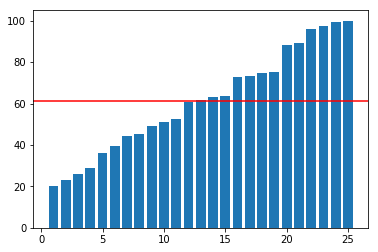

In [15]:
print percflows.describe()
y2 = percflows.percintflows.sort_values()
x2 = percflows.origin
plt.bar(x2, y2)
#mean line is skewed by a high value
#plt.axhline(y.mean(), color='red', label='Mean Flow Volume')
plt.axhline(y2.mean(), color='red', label='Mean Flow Volume')
plt.show()